# Library

In [ ]:
!pip install kmodes

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.preprocessing import MinMaxScaler
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
import pandas as pd
from IPython.display import Image, HTML
warnings.filterwarnings("ignore")

# Data Loading

In [21]:
url = "https://docs.google.com/spreadsheets/d/1-30mtmPNZCrBTkwQOqvKP9o9_LFnXGV8-BXokj6yQk0/export?format=csv&gid=0"

In [22]:
df = pd.read_csv(url)

In [23]:
df

,id,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,diabetic,halal,calories,image
0,1,Balu shahi,"Maida flour, yogurt, oil, sugar",vegetarian,45,25,sweet,dessert,1,1,93.0,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
1,2,Boondi,"Gram flour, ghee, sugar",vegetarian,80,30,sweet,dessert,1,1,69.0,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
2,3,Gajar ka halwa,"Carrots, milk, sugar, ghee, cashews, raisins",vegetarian,15,60,sweet,dessert,1,1,386.0,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
3,4,Ghevar,"Flour, ghee, kewra, milk, clarified butter, su...",vegetarian,15,30,sweet,dessert,1,1,74.0,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
4,5,Gulab jamun,"Milk powder, plain flour, baking powder, ghee,...",vegetarian,15,40,sweet,dessert,1,1,204.0,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
...,...,...,...,...,...,...,...,...,...,...,...,...
250,251,Til Pitha,"Glutinous rice, black sesame seeds, gur",vegetarian,5,30,sweet,dessert,1,1,240.0,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
251,252,Bebinca,"Coconut milk, egg yolks, clarified butter, all...",vegetarian,20,60,sweet,dessert,1,1,993.0,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
252,253,Shufta,"Cottage cheese, dry dates, dried rose petals, ...",vegetarian,-1,-1,sweet,dessert,0,1,824.0,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
253,254,Mawa Bati,"Milk powder, dry fruits, arrowroot powder, all...",vegetarian,20,45,sweet,dessert,0,1,242.0,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."


# EDA

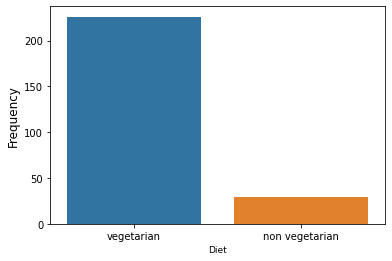

In [24]:
sns.countplot(df["diet"],label='count') #.set_xticklabels(['2011','2012','2013','2014','2015','2016','2017','2018'])
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Diet', fontsize=9)
plt.show()

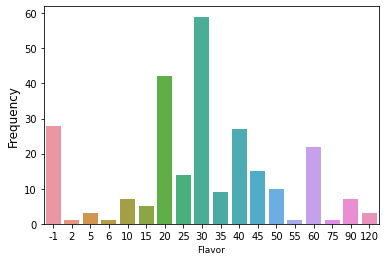

In [25]:
sns.countplot(df["cook_time"],label='count') #.set_xticklabels(['2011','2012','2013','2014','2015','2016','2017','2018'])
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Flavor', fontsize=9)
plt.show()

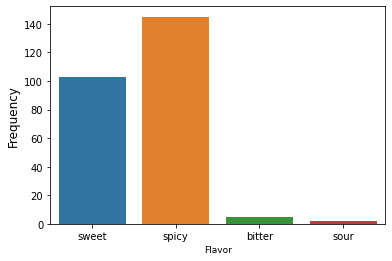

In [26]:
sns.countplot(df["flavor_profile"],label='count') #.set_xticklabels(['2011','2012','2013','2014','2015','2016','2017','2018'])
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Flavor', fontsize=9)
plt.show()

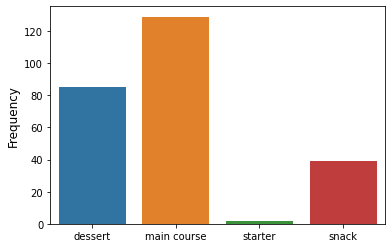

In [27]:
sns.countplot(df["course"],label='count') #.set_xticklabels(['2011','2012','2013','2014','2015','2016','2017','2018'])
plt.ylabel('Frequency', fontsize=12)
plt.xlabel("")
plt.show()

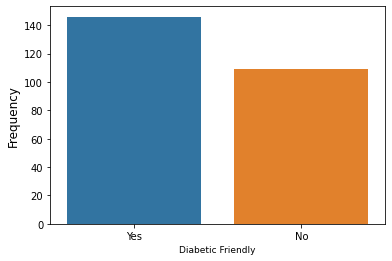

In [28]:
sns.countplot(df["diabetic"],label='count').set_xticklabels(['Yes','No'])
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Diabetic Friendly', fontsize=9)
plt.show()

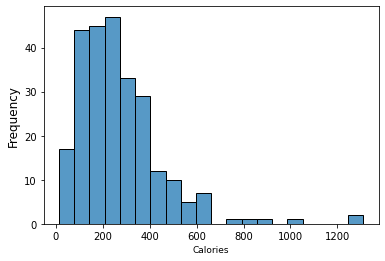

In [29]:
sns.histplot(df["calories"],label='count')
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Calories', fontsize=9)
plt.show()

# Preprocessing

In [30]:
df["flavor_profile"]=df["flavor_profile"].replace("-1","spicy")
df["cook_time"]=df["cook_time"].replace(-1,df["cook_time"].mean())

In [31]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['diet_label'] = labelencoder.fit_transform(df['diet'])
df['flavor_profile_label'] = labelencoder.fit_transform(df['flavor_profile'])
df['course_label'] = labelencoder.fit_transform(df['course'])
df
#df["course"].value_counts()

,id,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,diabetic,halal,calories,image,diet_label,flavor_profile_label,course_label
0,1,Balu shahi,"Maida flour, yogurt, oil, sugar",vegetarian,45,25.000000,sweet,dessert,1,1,93.0,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",1,3,0
1,2,Boondi,"Gram flour, ghee, sugar",vegetarian,80,30.000000,sweet,dessert,1,1,69.0,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",1,3,0
2,3,Gajar ka halwa,"Carrots, milk, sugar, ghee, cashews, raisins",vegetarian,15,60.000000,sweet,dessert,1,1,386.0,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",1,3,0
3,4,Ghevar,"Flour, ghee, kewra, milk, clarified butter, su...",vegetarian,15,30.000000,sweet,dessert,1,1,74.0,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",1,3,0
4,5,Gulab jamun,"Milk powder, plain flour, baking powder, ghee,...",vegetarian,15,40.000000,sweet,dessert,1,1,204.0,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,251,Til Pitha,"Glutinous rice, black sesame seeds, gur",vegetarian,5,30.000000,sweet,dessert,1,1,240.0,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",1,3,0
251,252,Bebinca,"Coconut milk, egg yolks, clarified butter, all...",vegetarian,20,60.000000,sweet,dessert,1,1,993.0,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",1,3,0
252,253,Shufta,"Cottage cheese, dry dates, dried rose petals, ...",vegetarian,-1,31.803922,sweet,dessert,0,1,824.0,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",1,3,0
253,254,Mawa Bati,"Milk powder, dry fruits, arrowroot powder, all...",vegetarian,20,45.000000,sweet,dessert,0,1,242.0,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",1,3,0


In [32]:
data = df[['name','ingredients', 'cook_time','calories','diabetic','diet_label','flavor_profile_label','course_label']]

In [33]:
from sklearn.preprocessing import MinMaxScaler
columns_to_normalize = ['cook_time','calories']
scaler = MinMaxScaler().fit(data[columns_to_normalize])
data[columns_to_normalize] = pd.DataFrame(scaler.transform(data[columns_to_normalize]))

In [34]:
data

,name,ingredients,cook_time,calories,diabetic,diet_label,flavor_profile_label,course_label
0,Balu shahi,"Maida flour, yogurt, oil, sugar",0.194915,0.061633,1,1,3,0
1,Boondi,"Gram flour, ghee, sugar",0.237288,0.043143,1,1,3,0
2,Gajar ka halwa,"Carrots, milk, sugar, ghee, cashews, raisins",0.491525,0.287365,1,1,3,0
3,Ghevar,"Flour, ghee, kewra, milk, clarified butter, su...",0.237288,0.046995,1,1,3,0
4,Gulab jamun,"Milk powder, plain flour, baking powder, ghee,...",0.322034,0.147149,1,1,3,0
...,...,...,...,...,...,...,...,...
250,Til Pitha,"Glutinous rice, black sesame seeds, gur",0.237288,0.174884,1,1,3,0
251,Bebinca,"Coconut milk, egg yolks, clarified butter, all...",0.491525,0.755008,1,1,3,0
252,Shufta,"Cottage cheese, dry dates, dried rose petals, ...",0.252576,0.624807,0,1,3,0
253,Mawa Bati,"Milk powder, dry fruits, arrowroot powder, all...",0.364407,0.176425,0,1,3,0


In [35]:
x_scaled = data.iloc[:, 2:].values

In [36]:
x_scaled 

array([[0.19491525, 0.06163328, 1.        , 1.        , 3.        ,
        0.        ],
       [0.23728814, 0.0431433 , 1.        , 1.        , 3.        ,
        0.        ],
       [0.49152542, 0.28736518, 1.        , 1.        , 3.        ,
        0.        ],
       ...,
       [0.25257561, 0.6248074 , 0.        , 1.        , 3.        ,
        0.        ],
       [0.36440678, 0.17642527, 0.        , 1.        , 3.        ,
        0.        ],
       [0.25257561, 0.09175655, 1.        , 1.        , 3.        ,
        0.        ]])

# Clustering Model

In [37]:
cost=[]
for i in range(2,20):
    kproto = KPrototypes(n_clusters=i, init='Cao')
    kproto.fit_predict(x_scaled, categorical=[2,3,4,5])
    cost.append(kproto.cost_)

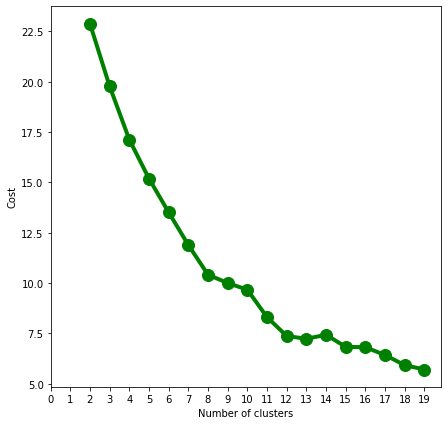

In [38]:
fig = plt.figure(figsize = (7,7))
plt.plot(range(2,20),cost, linewidth=4, markersize=12,marker='o',color = 'green')
plt.xticks(np.arange(20))
plt.xlabel("Number of clusters")
plt.ylabel("Cost")
plt.show()

In [39]:
kproto = KPrototypes(n_clusters=20, init='Cao', random_state=42)
clusters= kproto.fit_predict(x_scaled, categorical=[2,3,4,5])

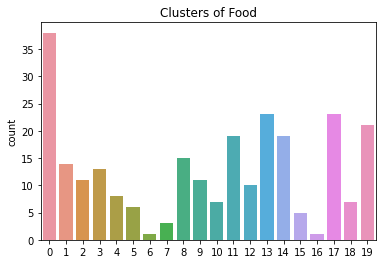

In [40]:
sns.countplot(clusters)
plt.title('Clusters of Food')
plt.show()

In [ ]:
data.insert(loc=0, column='cluster', value=clusters)

In [42]:
data

,cluster,name,ingredients,cook_time,calories,diabetic,diet_label,flavor_profile_label,course_label
0,19,Balu shahi,"Maida flour, yogurt, oil, sugar",0.194915,0.061633,1,1,3,0
1,19,Boondi,"Gram flour, ghee, sugar",0.237288,0.043143,1,1,3,0
2,1,Gajar ka halwa,"Carrots, milk, sugar, ghee, cashews, raisins",0.491525,0.287365,1,1,3,0
3,19,Ghevar,"Flour, ghee, kewra, milk, clarified butter, su...",0.237288,0.046995,1,1,3,0
4,17,Gulab jamun,"Milk powder, plain flour, baking powder, ghee,...",0.322034,0.147149,1,1,3,0
...,...,...,...,...,...,...,...,...,...
250,17,Til Pitha,"Glutinous rice, black sesame seeds, gur",0.237288,0.174884,1,1,3,0
251,18,Bebinca,"Coconut milk, egg yolks, clarified butter, all...",0.491525,0.755008,1,1,3,0
252,18,Shufta,"Cottage cheese, dry dates, dried rose petals, ...",0.252576,0.624807,0,1,3,0
253,11,Mawa Bati,"Milk powder, dry fruits, arrowroot powder, all...",0.364407,0.176425,0,1,3,0


In [43]:
df.insert(loc=0, column='cluster', value=clusters)

In [44]:
df

,cluster,id,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,diabetic,halal,calories,image,diet_label,flavor_profile_label,course_label
0,19,1,Balu shahi,"Maida flour, yogurt, oil, sugar",vegetarian,45,25.000000,sweet,dessert,1,1,93.0,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",1,3,0
1,19,2,Boondi,"Gram flour, ghee, sugar",vegetarian,80,30.000000,sweet,dessert,1,1,69.0,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",1,3,0
2,1,3,Gajar ka halwa,"Carrots, milk, sugar, ghee, cashews, raisins",vegetarian,15,60.000000,sweet,dessert,1,1,386.0,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",1,3,0
3,19,4,Ghevar,"Flour, ghee, kewra, milk, clarified butter, su...",vegetarian,15,30.000000,sweet,dessert,1,1,74.0,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",1,3,0
4,17,5,Gulab jamun,"Milk powder, plain flour, baking powder, ghee,...",vegetarian,15,40.000000,sweet,dessert,1,1,204.0,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,17,251,Til Pitha,"Glutinous rice, black sesame seeds, gur",vegetarian,5,30.000000,sweet,dessert,1,1,240.0,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",1,3,0
251,18,252,Bebinca,"Coconut milk, egg yolks, clarified butter, all...",vegetarian,20,60.000000,sweet,dessert,1,1,993.0,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",1,3,0
252,18,253,Shufta,"Cottage cheese, dry dates, dried rose petals, ...",vegetarian,-1,31.803922,sweet,dessert,0,1,824.0,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",1,3,0
253,11,254,Mawa Bati,"Milk powder, dry fruits, arrowroot powder, all...",vegetarian,20,45.000000,sweet,dessert,0,1,242.0,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",1,3,0


# Classification Model

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
X = data.iloc[:,3:].values
y= data['cluster'].values

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print('Total Rows Data X Training',X_train.shape[0])
print('Total Rows Data X Testing',X_test.shape[0])
print('Total Rows Data y Training',y_train.shape[0])
print('Total Rows Data y Testing',y_test.shape[0])

Total Rows Data X Training 204
Total Rows Data X Testing 51
Total Rows Data y Training 204
Total Rows Data y Testing 51


In [61]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
model=knn.fit(X_train,y_train)
y_pred = model.predict(X_test)
cr = classification_report(y_test, y_pred)
print(cr)
print('Akurasi Model :', accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         9
           1       1.00      0.75      0.86         4
           2       1.00      1.00      1.00         2
           3       0.80      1.00      0.89         4
           5       1.00      1.00      1.00         2
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         0
           9       1.00      1.00      1.00         3
          10       1.00      0.67      0.80         3
          11       1.00      1.00      1.00         4
          12       0.50      0.50      0.50         2
          13       0.75      1.00      0.86         3
          14       1.00      1.00      1.00         1
          15       0.00      0.00      0.00         4
          17       0.50      1.00      0.67         3
          18       0.00      0.00      0.00         1
          19       1.00      0.80      0.89         5

    accuracy              

In [62]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
model2= forest.fit(X_train,y_train)
y_pred2 = model2.predict(X_test)
cr2 = classification_report(y_test, y_pred2)
print(cr2)
print('Akurasi Model :', accuracy_score(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         9
           1       1.00      0.75      0.86         4
           2       1.00      1.00      1.00         2
           3       0.75      0.75      0.75         4
           5       1.00      1.00      1.00         2
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         0
           9       0.75      1.00      0.86         3
          10       1.00      0.67      0.80         3
          11       1.00      1.00      1.00         4
          12       0.50      0.50      0.50         2
          13       0.75      1.00      0.86         3
          14       1.00      1.00      1.00         1
          15       0.00      0.00      0.00         4
          17       0.60      1.00      0.75         3
          18       1.00      1.00      1.00         1
          19       1.00      0.80      0.89         5

    accuracy              

In [63]:
from sklearn.svm import SVC
svc = SVC()
model3=svc.fit(X_train,y_train)
y_pred3 = model3.predict(X_test)
cr3 = classification_report(y_test, y_pred3)
print(cr3)
print('Akurasi Model :', accuracy_score(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.60      1.00      0.75         9
           1       0.00      0.00      0.00         4
           2       1.00      1.00      1.00         2
           3       0.57      1.00      0.73         4
           5       1.00      1.00      1.00         2
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         0
           9       1.00      1.00      1.00         3
          10       1.00      0.67      0.80         3
          11       1.00      1.00      1.00         4
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         3
          14       1.00      1.00      1.00         1
          15       0.00      0.00      0.00         4
          17       0.23      1.00      0.38         3
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         5

    accuracy              

In [64]:
#Cross Validation
scores = cross_val_score(forest, X_train, y_train, cv=5)
cross_validation=pd.DataFrame(scores, columns=['cross_validation'])
print (cross_validation)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

   cross_validation
0          0.926829
1          0.878049
2          0.878049
3          0.878049
4          0.925000
0.90 accuracy with a standard deviation of 0.02


#### Classification with TensorFlow

In [65]:
import tensorflow as tf

modeltf = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation=tf.nn.relu, 
                          input_shape=(6,)),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

modeltf.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                448       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________


In [66]:
modeltf.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [67]:
history = modeltf.fit(X_train, y_train, epochs=500, verbose=0)

history.history['accuracy'][-1]

0.04901960864663124

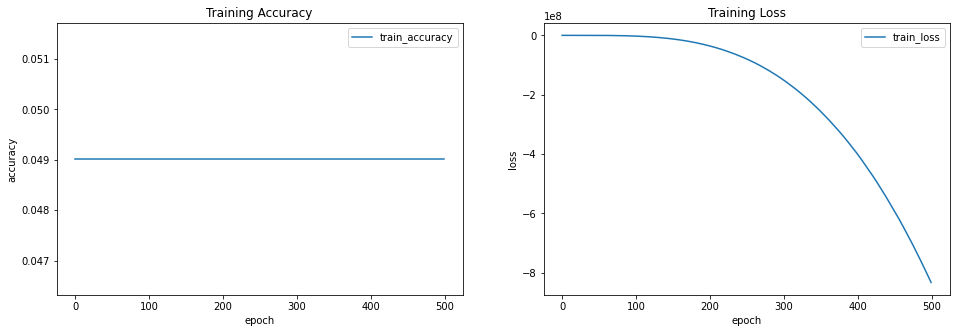

In [68]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy'], loc='best')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss'], loc='best')

In [69]:
y_predtf = modeltf.predict(X_test)
print('Akurasi Model :', accuracy_score(y_test, y_predtf))

Akurasi Model : 0.0784313725490196


# Input Data

vegetarian=1
non vegetarian=0

bitter=0
sour=1
spicy=2
sweet=3

dessert=0
main course=1
snack=2
starter=3

Diabetic Friendly
yes = 0
no = 1

halal
no = 0
yes = 1


In [73]:
country = input("Country? *India available ")
new_cook = input("Cooking Time(Minutes)? ")
new_calories =input("Calories(Kcal)? ")
new_diabetes =input("Diabetic Friendly? \n(0) Yes \n(1) No \n Please Select by Number: ")
new_diet =input("Diet? \n(0) Non Vegetarian \n(1) Vegetarian \n Please Select by Number: ")
new_flavor=input("Flavor? \n(0) Bitter \n(1) Sour \n(2) Spicy \n(3) Sweet \n Please Select by Number: ")
new_course=input("(0) Dessert \n(1) Main Course \n(2) Snack \n(3) Starter \n Please Select by Number: ")
print("Thank You!")

Country? *India available India
Cooking Time(Minutes)? 30
Calories(Kcal)? 205
Diabetic Friendly? 
(0) Yes 
(1) No 
 Please Select by Number: 0
Diet? 
(0) Non Vegetarian 
(1) Vegetarian 
 Please Select by Number: 0
Flavor? 
(0) Bitter 
(1) Sour 
(2) Spicy 
(3) Sweet 
 Please Select by Number: 2
(0) Dessert 
(1) Main Course 
(2) Snack 
(3) Starter 
 Please Select by Number: 0
Thank You!


# Predict New Data (Recommendation)

In [105]:
new_df = {'new_cook': [int(new_cook)],
        'new_calories': [int(new_calories)],
        'new_diabetes': [int(new_diabetes)],
        'new_diet':[int(new_diet)],
        'new_flavor' : [int(new_flavor)],
        'new_course': [int(new_course)]}
new_df = pd.DataFrame(new_df)
newcolumns_to_normalize = ['new_cook','new_calories']
new_df[newcolumns_to_normalize] = pd.DataFrame(scaler.transform(new_df[newcolumns_to_normalize]))
X_new = new_df.values
y_new = model2.predict(X_new)
r= data.loc[data["cluster"]==int(y_new)]
recommendation = r.iloc[:,1:3].reset_index(drop=True)
#recommendation

In [106]:
#Check Data
#df.loc[df["cluster"]==int(y_new)]
#data.loc[data["flavor_profile_label"]==1]
#data["flavor_profile_label"].value_counts()

,name,ingredients,image
0,Maach Jhol,"Fish, potol, tomato, chillies, ginger, garlic",
1,Pork Bharta,"Boiled pork, onions, chillies, ginger and garlic",
2,Galho,"Rice, axone, salt, water, chillies, pork",
3,Chicken razala,"Chicken, dahi, sesame seeds, garam masala powder, cashew nuts, saffron",
4,Tandoori Chicken,"Greek yogurt, garam masala, kasuri methi, marinade, mustard oil",
5,Beef Fry,"Beef, coconut, garam masala, curry leaves, green chilies, chili powder",
6,Chicken Varuval,"Meat curry powder, chicken chunks, ginger, tomato, cinnamon",
7,Kolim Jawla,"Baingan, fish, coconut oil, fresh coconut, ginger",
8,Vindaloo,"Chicken, coconut oil, wine vinegar, ginger, green, cinnamon",
9,Alu Pitika,"Potatoes, mustard oil, fish, green chillies",

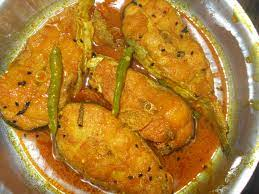
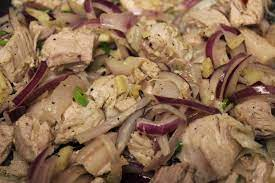
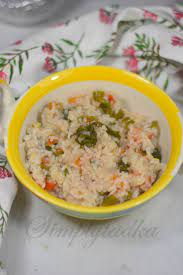
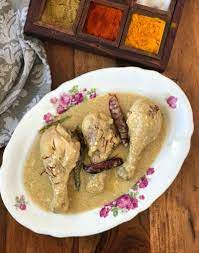
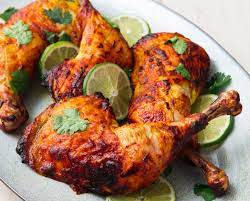
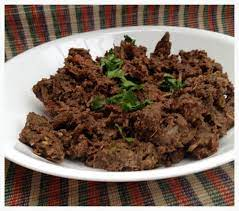
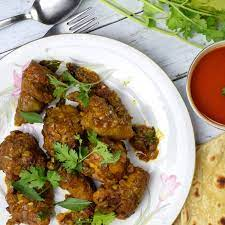
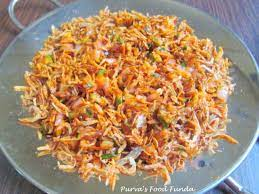
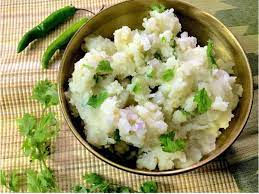
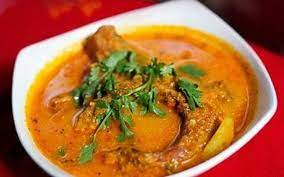
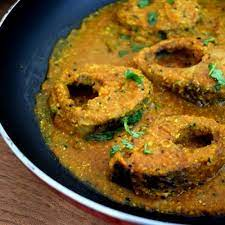
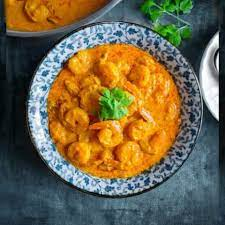
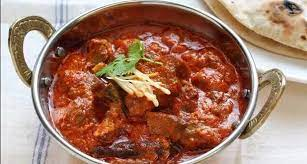
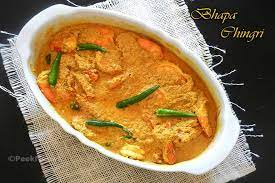
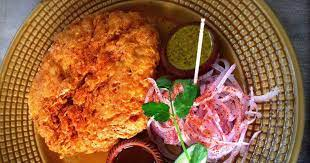
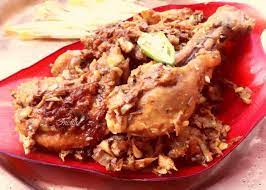
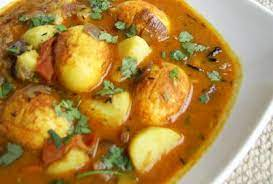
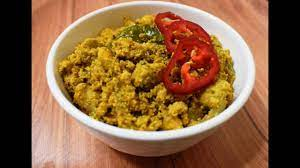

In [108]:
dfgambar = df.loc[df["cluster"]==int(y_new)]
coldel =["cluster","id","diet","prep_time","cook_time","flavor_profile","course","diabetic","halal","calories","diet_label","flavor_profile_label","course_label"]	
dfgambar.drop(coldel, inplace=True, axis=1)
dfgambar=dfgambar.reset_index(drop=True)
def path_to_image_html(path):
    '''
     This function essentially convert the image url to 
     '<img src="'+ path + '"/>' format. And one can put any
     formatting adjustments to control the height, aspect ratio, size etc.
     within as in the below example. 
    '''
    return '<img src="'+ path + '" style=max-height:124px;"/>'
final_recommendation = HTML(dfgambar.to_html(escape=False ,formatters=dict(image=path_to_image_html)))
final_recommendation